# P3 Final Project: OpenStreetMap Los Angeles

## Map Area

Los Angeles, CA, United States

- https://mapzen.com/data/metro-extracts/metro/los-angeles_california/

I wanted to choose just my hometown, but the file size was too small for this project.  As a result, I decided to use the Los Angeles extract because it included my hometown and many of the other areas in Southern California that I visited most often growing up.

## Problems Encountered in the Map

While exploring the data I encountered many problems.  Below are the problems I decided to fix.

- Second level "k" tags with unexpected "problem" characters in them.
- Second level “k” tags pulled from GPS data (such as Tiger GPS) and data imported from databases (like the GNIS database). These have a format such as "tiger:xxx", "tiger:xxx:xxx", and "gnis:xxx".
- Abbreviated street names (like "Ave", "St", and "Ct").
- Postal codes with "CA" at the beginning (like "CA 90274"), a mixture of five and 9 digit postal codes (like "91325" and "91325-3301"), and information that are not postal codes listed as such (like full addresses, random numbers, or place names).

## Data Wrangling Phase

In [1]:
import xml.etree.cElementTree as ET
import re
import pprint

filename = 'los-angeles_california.osm'

To begin I wanted to get a feel for the data by finding out what tags are present and how many of each tag there are.

In [2]:
def get_element(f):
    """Yields element if it is the right type of tag"""
    context = ET.iterparse(f, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end':
            yield elem
            root.clear()
            
def count_tags(f):
    """Counts the number of top level tags"""
    tags = {}
    for elem in get_element(f):
        if elem.tag not in tags.keys():
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
        elem.clear()
    return tags

#pprint.pprint(count_tags(filename))

Next, I wanted to check the formating of the tags.

Before I processed the data and added it into my database, I decided to check the "k" value for each "tag" and see if there were any potential problems.

To do this, I used the function 'key_type' below to get a count of each of
four tag categories in a dictionary:
 - "lower" for tags that contain only lowercase letters and are valid
 - "lower_colon" for otherwise valid tags with a colon in their names
 - "problemchars" for tags with problematic characters
 - "other" for other tags that do not fall into the other three categories.
 
After that, I used the "print_key_type" function to print out the attributes for the tag categories "problemchars" and "others" to see what changes, if any, needed to be made to the tags in these categories.

In [3]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+\&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(elem, keys):
    """Updates the 'key' dictionary with a count of each key type"""
    if elem.tag == "tag":
        k = elem.attrib['k']
        if lower.search(k):
            keys['lower'] += 1
        elif lower_colon.search(k):
            keys['lower_colon'] += 1
        elif problemchars.search(k):
            keys['problemchars'] += 1    
        else:
            keys['other'] += 1
    return keys

def process_map(f):
    """Replaces the 'keys' dictionary with the updated 'keys' dictionary created by the 'key_type' function"""
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for elem in get_element(f):
        keys = key_type(elem, keys)
    return keys

#pprint.pprint(process_map(filename))

In [4]:
def print_key_type(f):
    """Checks the element's key type, appends it to appropriate list, and returns the list"""
    prob_char = []
    other_prob = []
    for elem in get_element(f):
        if elem.tag == "tag":
            k = elem.attrib['k']
            if lower.search(k):
                continue
            elif lower_colon.search(k):
                continue
            elif problemchars.search(k):
                prob_char.append(elem.attrib)
            else:
                other_prob.append(elem.attrib)
    return prob_char, other_prob

#pprint.pprint(print_key_type(filename))

The tags in the "problemchars" category, were flagged due to periods in between two words (like "step.height"), and whitespace between multiples words (such as "business type").
I decided to correct these problems by getting rid of the periods in between words and connecting all the 'k' attributes using underscores.

In addition, the "others" category was filled with many different kinds of attributes.  Many where just simply annotations such as "FIXME" and "Description", so I will leave those alone.  Many others are GPS data (such as Tiger GPS) and data imported from databases (like the GNIS database).  These have a format such as "tiger:xxx", "tiger:xxx:xxx", and "gnis:xxx".  I will fix "k" attributes with colons in them like this later in the "shape_element" function in the "CSV File Creation" section below.

Next, I checked for street names in the database and flagged any street names that weren't in the "expected" list shown in the code below.  I then printed out the flagged street names to decide which ones needed changed.

In [5]:
from collections import defaultdict

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons"]

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(f):
    """Checks if each element is a street, checks each element for the words in the 'expected' list, 
    adds it to the 'street_types' ditionary, and returns the dictionary"""
    street_types = defaultdict(set)
    for elem in get_element(f):
        if elem.tag == "tag":
            if is_street_name(elem):
                audit_street_type(street_types, elem.attrib['v'])
    return street_types

#pprint.pprint(dict(audit(filename)))

Most of the problems I found with the street names involved the use of abbreviations.  These problems will be taken care of using the "update_street_name" function defined within the "shape_element" in the "CSV File Creation" section below.  Other problems, which I will not be cleaning pragmatically at this time, were street names that included the postal codes (such as '90815': set(['90815'])) and numbers that are likely the house numbers, suite numbers, apartment numbers, etc...(such as '100': set(['3347 Michelson Dr Suite 100'])).

I could have just deleted postal codes that were mistakingly listed as street names or get rid of full addresses, but I didn't want to lose that information when it could still be transfered to a different "k" attribute other than "addr:street".  So, in the end, I chose to simply leave them as is for the sake of time and effort required for so few entries.

In [6]:
from collections import defaultdict

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")

def audit(f):
    """Checks if the element's tag-attribute is a postal code, adds it to the 'postal_code' dictionary if it is,
       and returns the dictionary"""
    postal_codes = defaultdict(set)
    for elem in get_element(f):
        if elem.tag == "tag":
            if is_postal_code(elem):
                postal_codes[elem.attrib['v']].add(elem.attrib['v'])
    return postal_codes

#pprint.pprint(dict(audit(filename)))

Next I turned to looking at postal codes.  After using the "audit" function above to print out the postal codes, I was able to see the variety of format's people used.  The main kinds of postal codes I found were regular five digit codes (like "91325"), nine digit codes (like "91325-3301"), five and nine digit postal codes with "CA" at the beginning with a space or dash (like "CA 90274"), and information that is not postal codes (like full addresses, random numbers, or place names).

In [7]:
five_digit = re.compile(r'^(\d{5})$')
nine_digit = re.compile(r'^(\d{5}-\d{4})$')
letter_nine_digit_dash = re.compile(r'^([A-Z])+-(\d{5}-\d{4})$')
letter_nine_digit_space = re.compile(r'^([A-Z])+\s(\d{5}-\d{4})$')
letter_five_digit = re.compile(r'^([a-zA-Z])+\s(\d{5})$')
phone_number = re.compile(r'^(\d{5}-\d{4})\s(\d+-\d+-\d+)$')

def postal_code_key_type(elem, keys):
    if elem.tag == "tag":
        code = elem.attrib['v']
        if nine_digit.search(code):
            keys['nine_digit'] += 1
        elif five_digit.search(code):
            keys['five_digit'] += 1
        elif letter_five_digit.search(code):
            keys['letter_five_digit'] += 1
        elif letter_nine_digit_dash.search(code):
            keys['letter_nine_digit_dash'] += 1
        elif letter_nine_digit_space.search(code):
            keys['letter_nine_digit_space'] += 1
        elif phone_number.search(code):
            keys['phone_number'] += 1
        else:
            keys['other'] += 1
    return keys

def process_map(f):
    """Checks if each element is a postal code, checks each element's key type with a regular expression, 
       updates dictionary key type count, and returns dictionary"""
    keys = {"five_digit": 0,
            "nine_digit": 0,
            "letter_nine_digit_space": 0,
            "letter_nine_digit_dash": 0,
            "letter_five_digit": 0,
            "phone_number": 0,
            "other": 0}
    for elem in get_element(f):
        if elem.tag == "tag":
            if is_postal_code(elem):
                keys = postal_code_key_type(elem, keys)
    return keys

#pprint.pprint(process_map(filename))

As can be seen in the output above, the vast majority of the postal codes were regular five digit codes, but there were postal codes in other formats and some non-postal codes.  While the postal codes in other formats are not necessarily a problem, I want as much uniformity as possible.  As a result, I will process those otherwise correct postal codes into five digit codes (this will be taken care of using the "clean_postal_code" function defined within the "shape_element" function in the "CSV File Creation" section below).

The "print_postal_key_types"function below was simply used by me to make sure I was capturing all of the postal codes correctly.

In [8]:
def postal_code_key_type(elem, postal_codes):
    code = elem.attrib['v']
    if nine_digit.search(code):
        postal_codes['nine_digit'].add(code)
    elif five_digit.search(code):
        postal_codes['five_digit'].add(code)
    elif letter_five_digit.search(code):
        postal_codes['letter_five_digit'].add(code)
    elif letter_nine_digit_dash.search(code):
        postal_codes['letter_nine_digit_dash'].add(code)
    elif letter_nine_digit_space.search(code):
        postal_codes['letter_nine_digit_space'].add(code)
    elif phone_number.search(code):
        postal_codes['phone_number'].add(code)
    else:
        postal_codes['other'].add(code)
    return postal_codes

def print_postal_key_types(f):
    """Checks if each element is a postal code, checks each element's key type with a regular expression, 
    adds element to dictionary, and returns dictionary"""
    postal_codes = defaultdict(set)
    for elem in get_element(f):
        if elem.tag == "tag":
            if is_postal_code(elem):
                postal_code_key_type(elem, postal_codes)
    return postal_codes

#pprint.pprint(dict(print_postal_key_types(filename)))

## CSV File Creation

In [10]:
import csv
import codecs
import cerberus
import schema

OSM_PATH = filename

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

# The dictionary of street names to be updated using the "update_street_name" function defined below.
mapping = { "Av": "Avenue",
            "Ave,": "Avenue",
            "Ave.": "Avenue",
            "Ave": "Avenue",
            "avenue": "Avenue",
            "ave": "Avenue",
            "BLVD": "Boulevard",
            "Blv": "Boulevard",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "blvd": "Boulevard",
            "Bvd": "Boulevard",
            "broadway": "Broadway",
            "Cir": "Circle",
            "Ct": "Court",
            "court": "Court",
            "ct.": "Court",
            "Dr": "Drive",
            "Dr.": "Drive",
            "Hwy": "Highway",
            "Ln": "Lane",
            "Ln.": "Lane",
            "Pkwy": "Parkway",
            "Pkwy.": "Parkway",
            "Pky": "Parkway",
            "PL": "Place",
            "Pl": "Place",
            "RD": "Road",
            "Rd": "Road",
            "Rd.": "Road",
            "road": "Road",
            "Sq": "Square",
            'Sreet': "Street",
            "ST": "Street",
            "St": "Street",
            "St.": "Street",
            "street": "Street",
            "WAY": "Way",
            'Wy': "Way",
            "way": "Way"
            }

SCHEMA = schema.schema

# The field names that will be used in the header rows of the csv files defined above.
node_fields = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
node_tags_fields = ['id', 'key', 'value', 'type']
way_fields = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
way_tags_fields = ['id', 'key', 'value', 'type']
way_nodes_fields = ['id', 'node_id', 'position']


def shape_element(element):
    """Cleans and shapes node or way XML elements to Python dictionary"""
    
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []

    def update_street_name(child, mapping):
        """Checks if child element is a street, checks each child against the 'mapping' dictionary,
           and updates each street name according the the 'mapping' dictionary"""
        
        name = child.attrib['v']
        m = street_type_re.search(name)
        if m:
            street_type = m.group()
            if street_type in mapping.keys():
                name = re.sub(m.group(), mapping[m.group()], name)
        return name
    
    def clean_postal_code(child):
        """Checks if child element is a postal code, checks postal codes format against regular expressions,
           and cleans the postal code"""
        
        code = child.attrib['v']
        if nine_digit.search(code):
            code = code.split('-')[0]
        elif letter_nine_digit_dash.search(code):
            code = code.split('-')[1]
        elif letter_nine_digit_space.search(code):
            code = code.split(' ')[1]
        elif letter_five_digit.search(code):
            code = code.split(' ')[1]
        elif phone_number.search(code):
            code = code.split('-')[0]
        return code
    
    def fix_key_type(element, child):
        
        tags_dict = {}
        tags_dict['id'] = element.attrib['id']    
                
        k = child.attrib['k']
        v = child.attrib['v']
        if lower.search(k):
            tags_dict['key'] = k
            tags_dict['type'] = 'regular'
            tags_dict['value'] = v
        elif problemchars.search(k):
            if k.find(" ") != -1:
                tags_dict['key'] = k.replace(" ", "_")
                tags_dict['type'] = 'regular'
                tags_dict['value'] = v
            elif k.find(".") != -1:
                tags_dict['key'] = k.replace(".", "_")
                tags_dict['type'] = 'regular'
                tags_dict['value'] = v
        elif lower_colon.search(k):
            if is_postal_code(child):
                tags_dict['value'] = clean_postal_code(child)
            elif is_street_name(child):
                tags_dict['value'] = update_street_name(child, mapping)
            else:
                tags_dict['value'] = v
            tags_dict["type"] = k.split(":", 1)[0]
            tags_dict["key"] = k.split(":", 1)[1]
        else:
            tags_dict["key"] = k
            tags_dict["type"] = 'irregular'
            tags_dict['value'] = v
        tags.append(tags_dict)


    if element.tag == 'node':
        for field in node_fields:
            try:
                node_attribs[field] = element.attrib[field]
            except:
                # print out problem "field" to see what the issue is
                #print(field)
                # if the attribute doesn't exist, fill it with something
                node_attribs[field] = '000'
        for child in element:
            if child.tag == 'tag':
                fix_key_type(element, child)
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        count = 0
        for field in way_fields:
            way_attribs[field] = element.attrib[field]
        for child in element:
            if child.tag == 'nd':
                nd_dict = {}
                nd_dict['id'] = element.attrib['id']
                nd_dict['node_id'] = child.attrib['ref']
                nd_dict['position'] = count
                count += 1
                way_nodes.append(nd_dict)
            elif child.tag == 'tag':
                fix_key_type(element, child)
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yields element if it is the right type of tag"""
    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

def validate_element(element, validator, schema=SCHEMA):
    """Raises ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))

class UnicodeDictWriter(csv.DictWriter, object):
    """Extends csv.DictWriter to handle Unicode input"""
    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively processes each XML element and writes it to csv(s)"""
    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, node_fields)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, node_tags_fields)
        ways_writer = UnicodeDictWriter(ways_file, way_fields)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, way_nodes_fields)
        way_tags_writer = UnicodeDictWriter(way_tags_file, way_tags_fields)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])

if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    from time import time
    t0 = time()
    process_map(OSM_PATH, validate=False)
    print "Time To Process: {} Seconds".format(time()-t0)

Time To Process: 1383.583565 Seconds


# Database and Table Creation

In [1]:
import sqlite3
import csv
import os
import math
from time import time
from pprint import pprint
from decimal import Decimal
from UploadSplitCSVFiles import UploadSplitCSVFiles

uploadSplit = UploadSplitCSVFiles()

db = 'Los_Angeles.db'    # name of the sqlite database file

# Connect to the database
#conn = sqlite3.connect(db)

# Get a cursor object
#cur = conn.cursor()

Three of the five csv files were too large to upload whole into my database and would freeze up my computer.  As a result I used a class function called "UploadSplitCSVFiles()" that splits the original csv file into a specified number of smaller files and uploads it to the table in batches.  The code I used can be found here: https://discussions.udacity.com/t/memory-error-nodes-csv-to-sql-database/186806

In [2]:
uploadSplit.uploadPartCSVFiles(db,'nodes.csv',30)

Number of rows in file: ................: 27327575
Time taken to count csv file: ..........: 30.27 secs
Number of rows per new file: ...........: 910920
Time taken to create csv files: ........: 104.55 secs
The original csv file size is...........: 2531 MB
The database file size is...............: 3617 MB
Time taken to upload csv files: ........: 437.97 secs


In [2]:
conn = sqlite3.connect(db)

cur = conn.cursor()

cur.execute('DROP TABLE IF EXISTS nodes_tags')
conn.commit()

cur.execute('''
    CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
    )
''')
conn.commit()

t0 = time()
with open('nodes_tags.csv','rb') as fin:
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['id'].decode("utf-8"), i['key'].decode("utf-8"),i['value'].decode("utf-8"), i['type'].decode("utf-8")) for i in dr]

cur.executemany("INSERT INTO nodes_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()

print '{:.<40s}: {:.0f} MB'.format('The csv file size is',os.path.getsize('nodes_tags.csv')/1.0e6)
print '{:.<40s}: {:.0f} MB'.format('The database file size is',os.path.getsize(db)/1.0e6)
print '{:.<40s}: {:.2f} secs'.format('Time taken to upload csv files: ', Decimal(time()-t0))

conn.close()

The csv file size is....................: 35 MB
The database file size is...............: 3617 MB
Time taken to upload csv files: ........: 8.72 secs


In [2]:
conn = sqlite3.connect(db)

cur = conn.cursor()

cur.execute('DROP TABLE IF EXISTS ways')
conn.commit()

cur.execute('''
    CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT
    )
''')
conn.commit()

t0 = time()
with open('ways.csv','rb') as fin:
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['id'].decode('utf-8'), i['user'].decode('utf-8'), i['uid'].decode('utf-8'), i['version'].decode('utf-8'), i['changeset'].decode('utf-8'), i['timestamp'].decode('utf-8')) for i in dr]

cur.executemany("INSERT INTO ways(id, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?);", to_db)
conn.commit()

print '{:.<40s}: {:.0f} MB'.format('The csv file size is',os.path.getsize('ways.csv')/1.0e6)
print '{:.<40s}: {:.0f} MB'.format('The database file size is',os.path.getsize(db)/1.0e6)
print '{:.<40s}: {:.2f} secs'.format('Time taken to upload csv files: ', Decimal(time()-t0))

conn.close()

The csv file size is....................: 185 MB
The database file size is...............: 3617 MB
Time taken to upload csv files: ........: 45.47 secs


In [2]:
uploadSplit.uploadPartCSVFiles(db,'ways_nodes.csv',10)

Number of rows in file: ................: 30747777
Time taken to count csv file: ..........: 32.35 secs
Number of rows per new file: ...........: 3074778
Time taken to create csv files: ........: 66.47 secs
The original csv file size is...........: 742 MB
The database file size is...............: 2315 MB
Time taken to upload csv files: ........: 356.27 secs


In [2]:
uploadSplit.uploadPartCSVFiles(db,'ways_tags.csv',10)

Number of rows in file: ................: 17631440
Time taken to count csv file: ..........: 68.13 secs
Number of rows per new file: ...........: 1763144
Time taken to create csv files: ........: 81.16 secs
The original csv file size is...........: 597 MB
The database file size is...............: 2315 MB
Time taken to upload csv files: ........: 199.73 secs


## Database Queries

### File Sizes

The relevant information is listed above in the outputs of the "Database and Table Creation"  section, but I will list them all here for easier reference:

- los-angeles_california.osm: 6.4 GB
- Los_Angeles.db: 3.0 GB
- nodes.csv: 2.5 GB
- nodes_tags.csv: 35 MB
- ways.csv: 185 MB
- ways_nodes.csv: 742 MB
- ways_tags.cv: 597 MB  

### Number of Unique Users

In [3]:
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect(db)

cur = conn.cursor()

Populating the interactive namespace from numpy and matplotlib


In [4]:
cur.execute('SELECT COUNT(DISTINCT uid) FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways)')
pprint(cur.fetchall())

[(3650,)]


### Number of Nodes and Ways

In [5]:
cur.execute('SELECT COUNT(*) FROM nodes')
pprint(cur.fetchall())

[(27327574,)]


In [6]:
cur.execute('SELECT COUNT(*) FROM ways')
pprint(cur.fetchall())

[(2746825,)]


### Number Types of Nodes

In [9]:
node_types = pd.read_sql_query('SELECT key, COUNT(*) AS num FROM nodes_tags GROUP BY key ORDER BY num DESC LIMIT 10', conn)
node_types

,key,num
0,highway,89645
1,source,86923
2,street,75537
3,housenumber,75441
4,city,72018
5,postcode,71583
6,power,40220
7,building,39209
8,natural,39048
9,country,34359


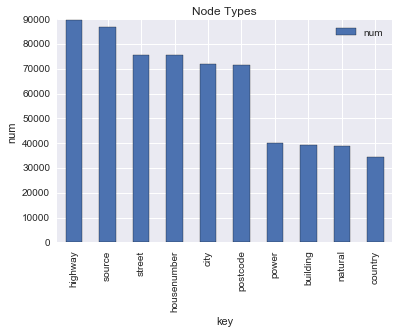

In [19]:
node_types.plot(x='key', kind='bar', title='Node Types').set(ylabel='num')

## Additional Statistics

### Number of Types of Ways

In [20]:
way_types = pd.read_sql_query('SELECT key, COUNT(*) AS num FROM ways_tags GROUP BY key ORDER BY num DESC LIMIT 10', conn)
way_types

,key,num
0,building,2100966
1,ele,1969568
2,bld_id,1967610
3,ain,1966808
4,height,1959561
5,start_date,1879931
6,units,1804102
7,highway,496893
8,name,353731
9,source,248897


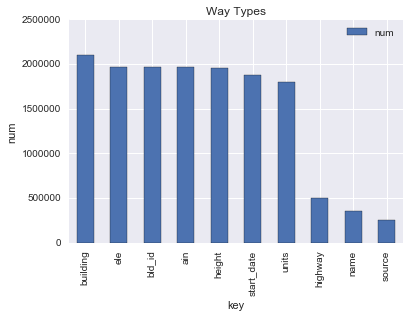

In [21]:
way_types.plot(x='key', kind='bar', title='Way Types').set(ylabel='num')

Not knowing what some of these way keys stood for I looked them up. and, interestingly, "bld_id", "ain" are very specific to Los Angeles County:
https://wiki.openstreetmap.org/wiki/Key:lacounty:bld_id and https://wiki.openstreetmap.org/wiki/Key:lacounty:ain

Also, it was interesting to see what I see more mundane tags (such as "height", "start_date", and "units") at the top of the list.  After searching for them to get their exact meanings, I found that there isn't an actual OSM key named "units".  I'm not sure why "units" became so prevalent if it isn't standard, so I will likely need to do some further data wrangling to get to the bottom of this mystery.

### Most Common Highway Types

In [22]:
highway_types = pd.read_sql_query('SELECT DISTINCT value, COUNT(*) as num FROM ways_tags WHERE key = "highway" GROUP BY value ORDER BY num \
DESC LIMIT 10', conn)
highway_types

,value,num
0,residential,199543
1,service,96711
2,secondary,45911
3,primary,40716
4,footway,31436
5,tertiary,24427
6,track,14179
7,motorway_link,11969
8,path,7821
9,motorway,7561


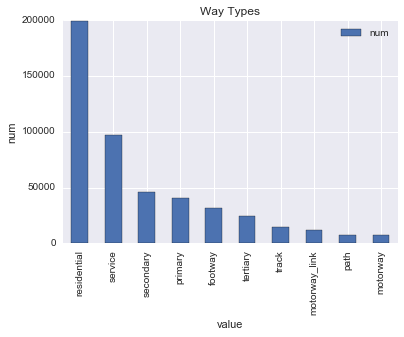

In [25]:
highway_types.plot(x='value', kind='bar', title='Way Types').set(ylabel='num')

In [ ]:
highway_types_2 = pd.read_sql_query('SELECT DISTINCT value, COUNT(*) as num FROM ways_tags WHERE key = "highway" GROUP BY value ORDER BY num \
DESC LIMIT 10', conn)

### Most Common Amenities

In [26]:
amenities = pd.read_sql_query('SELECT value, COUNT(*) as num FROM nodes_tags WHERE key = "amenity" GROUP BY value ORDER BY num \
DESC LIMIT 10', conn)
amenities

,value,num
0,place_of_worship,3700
1,school,2873
2,restaurant,2642
3,fast_food,1421
4,fuel,838
5,bench,791
6,cafe,771
7,fountain,699
8,toilets,591
9,drinking_water,523


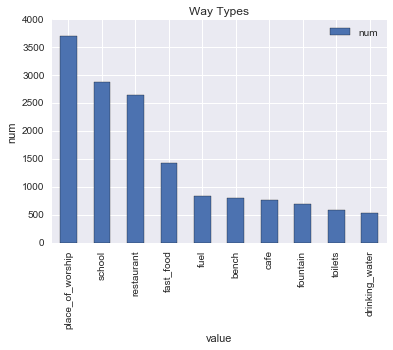

In [27]:
amenities.plot(x='value', kind='bar', title='Way Types').set(ylabel='num')

In [28]:
conn.close()

##  Conclusion and Aditional Ideas

Although I believe the data was cleaned well enough for the purposes of this project, there are many different tag attributes that I have yet to look at in detail.  As a result it is obvious that there is still a lot of cleaning left to be done.

One thing I think needs to be done is some sort of work to help standardize the labels for different map features.  Especially when it comes to GPS data.  While the OSM Wiki page offers standards for labeling different map features (https://wiki.openstreetmap.org/wiki/Map_Features), this seems to only apply for manually imputed data.  As a result, there is a disconnect between manually imputed data and automatically generated GPS data.  Perhaps the people at OSM could collaborate with the popular GPS system makers to better standardize how their data is formatted for OSM mapping.  However, it could be difficult to get these companies to collaborate on this since they are in competition with each other.  Also, even if the companies could be made to collaborate, doing so could lead to an over-reliance on GPS generated data and push out people who want to add information by hand.

In the meantime, for purposes of easier querying within my database, I could possibly standardize the data myself by changing either the GPS generated tag attributes to match with the OSM provided map feature labels.

## References

### General
- https://gist.github.com/carlward/54ec1c91b62a5f911c42
- https://discussions.udacity.com/t/workflow-for-project/182916
- https://discussions.udacity.com/t/a-question-about-the-scope-of-data-cleaning/161724

### Data Wrangling
- https://discussions.udacity.com/t/apply-tag-types-function/181950
- https://regex101.com/#python

### CSV File Creation
- https://discussions.udacity.com/t/p3-viewing-sample-of-osm-data/179293/5
- https://discussions.udacity.com/t/memory-error-nodes-csv-to-sql-database/186806
- https://discussions.udacity.com/t/preparing-for-database-attributeerror-str-object-has-no-attribute-attrib/200099
- https://discussions.udacity.com/t/keyerror-user/174898
- https://discussions.udacity.com/t/process-map-shape-element-function/194007

### Database and Table Creation
- https://discussions.udacity.com/t/creating-db-file-from-csv-files-with-non-ascii-unicode-characters/174958/7
- https://discussions.udacity.com/t/memory-error-nodes-csv-to-sql-database/186806